## Construction Verification - DIA data products

March 2025

During JTM 2025, Jeff had a session for working through some of the data management system requirements. This notebook uses w_2025_11 and/or w_2025_12 to load relevant data products and verify they have required features per [LSE-61](https://lse-61.lsst.io).

The following Requirements are covered in this notebook:

* **DMS-REQ-0074** (difference images)
* **DMS-REQ-0269** (diaSource measurements)

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.cm
import lsst.daf.butler as dafButler
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

In [2]:
repo = '/repo/main'
instrument = 'LSSTComCam'
skymap = 'lsst_cells_v1'
collections = 'LSSTComCam/runs/DRP/DP1/w_2025_09/DM-49235'

In [3]:
butler = dafButler.Butler(repo, collections=collections, instrument=instrument, skymap=skymap)

## The first requirement concerns difference images

We will load a representative ComCam difference image and show it has the required features.

>**DMS-REQ-0074**
For each Difference Exposure, the DMS shall store: the identify of the input exposures and related provenance information, and a set of metadata attributes including at least a representation of the PSF matching kernel used in the differencing.

In [4]:
diffim = butler.get('goodSeeingDiff_differenceExp', visit=2024111600297, detector=1)

In [5]:
#diaSources = butler.get('goodSeeingDiff_diaSrc', visit=2024111600297, detector=1)  # raw afw table
diaSources = butler.get('goodSeeingDiff_diaSrcTable', visit=2024111600297, detector=1)  # filtered pandas dataframe

In [6]:
diaSources.columns

Index(['diaSourceId', 'visit', 'detector', 'band', 'diaObjectId', 'ssObjectId',
       'parentDiaSourceId', 'midpointMjdTai', 'bboxSize', 'time_processed',
       'ra', 'dec', 'raErr', 'decErr', 'ra_dec_Cov', 'x', 'y', 'xErr', 'yErr',
       'apFlux', 'apFluxErr', 'snr', 'psfFlux', 'psfFluxErr', 'psfChi2',
       'psfNdata', 'trailFlux', 'trailRa', 'trailDec', 'trailLength',
       'trailAngle', 'dipoleMeanFlux', 'dipoleMeanFluxErr', 'dipoleFluxDiff',
       'dipoleFluxDiffErr', 'dipoleLength', 'dipoleAngle', 'dipoleChi2',
       'isDipole', 'dipoleFitAttempted', 'dipoleNdata', 'scienceFlux',
       'scienceFluxErr', 'ixx', 'iyy', 'ixy', 'ixxPSF', 'iyyPSF', 'ixyPSF',
       'extendedness', 'reliability', 'pixelFlags', 'pixelFlags_offimage',
       'pixelFlags_edge', 'pixelFlags_interpolated', 'pixelFlags_saturated',
       'pixelFlags_cr', 'pixelFlags_bad', 'pixelFlags_suspect',
       'pixelFlags_interpolatedCenter', 'pixelFlags_saturatedCenter',
       'pixelFlags_crCenter', 'pixelFl

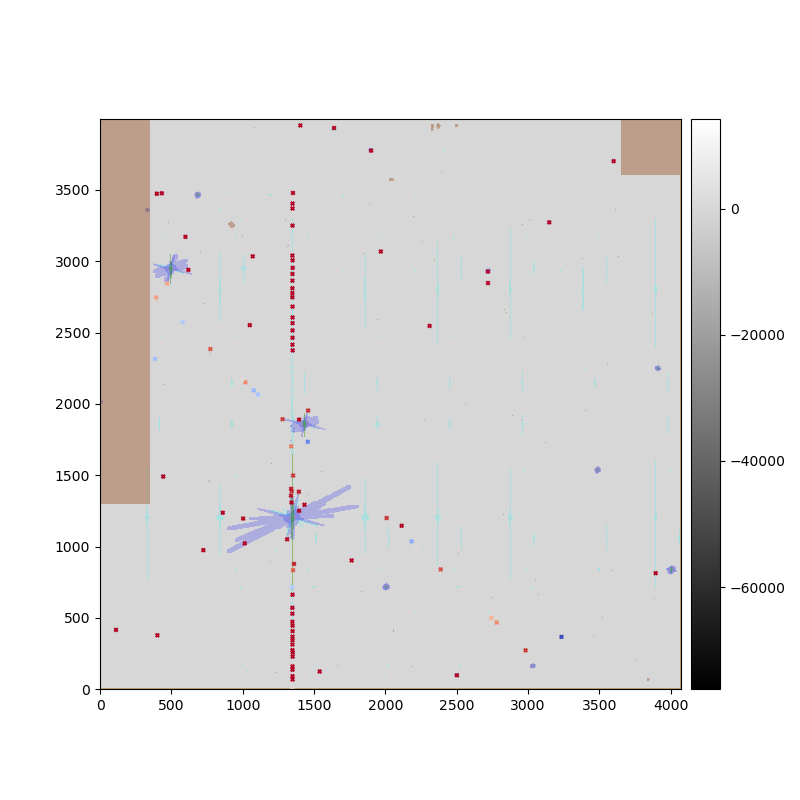

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
cmap = matplotlib.cm.coolwarm_r
disp = afwDisplay.Display(fig)
#disp.setMaskPlaneColor("STREAK", color="darkolivegreen")
disp.setMaskTransparency(80)
#disp.scale("asinh", "zscale") # TODO: figure out a reasonable scale to use
disp.image(diffim.maskedImage)
for idx, row in diaSources.iterrows():
    disp.dot('x', row['x'], row['y'], size=10, ctype=cmap(row.reliability))
plt.show()

To retrieve the input exposures, it is necessary to use the same dataId (i.e., visit and detector) and to know the names of the datasetTypes for a science exposure and a template exposure. For the present DP1 processing run, these are `calexp` and `goodSeeingDiff_templateExp`, respectively.

In [8]:
science = butler.get('calexp', visit=2024111600297, detector=1)
template = butler.get('goodSeeingDiff_templateExp', visit=2024111600297, detector=1)

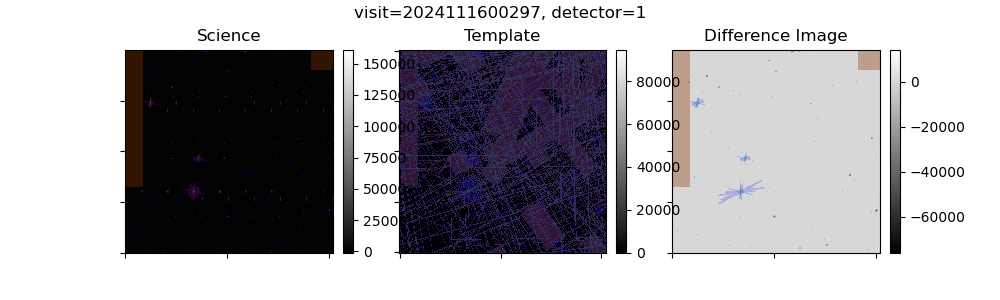

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(10,3))
disp = afwDisplay.Display(fig)
disp.setMaskTransparency(80)
#disp.scale("linear", min=-2000, max=2000)
#disp.scale("asinh", "zscale")
plt.sca(axs[0])
disp.image(science.maskedImage)
plt.sca(axs[1])
disp.image(template.maskedImage)
plt.sca(axs[2])
disp.image(diffim.maskedImage)
axs[0].set_title('Science')
axs[1].set_title('Template')
axs[2].set_title('Difference Image')
fig.suptitle('visit=2024111600297, detector=1')
axs[0].set_xticklabels('')
axs[1].set_xticklabels('')
axs[2].set_xticklabels('')
axs[0].set_yticklabels('')
axs[1].set_yticklabels('')
axs[2].set_yticklabels('')
plt.show()

To access metadata such as the PSF matching kernel used during differencing, users can load the `goodSeeingDiff_psfMatchKernel`.

To inspect it, you must provide an x and y position in the difference image, and a small ImageD object that will be written into when you call `computeImage`. You can also specify whether or not to normalize it by passing the optional bool `doNormalize`.

In [15]:
kernel = butler.get('goodSeeingDiff_psfMatchKernel', visit=2024111600297, detector=1)

In [16]:
diffim.psf.getAveragePosition()  # one way to get the approximate (x, y) position near the diffim center

Point2D(2009.5647677185639, 2006.569930517431)

In [17]:
kernelImage = afwImage.ImageD(kernel.getDimensions())  # placeholder

In [20]:
kernel.computeImage(kernelImage,
                    doNormalize=False,
                    x=diffim.psf.getAveragePosition().x,
                    y=diffim.psf.getAveragePosition().y)

1.0011026797791611

Text(0.5, 1.0, 'PSF matching kernel')

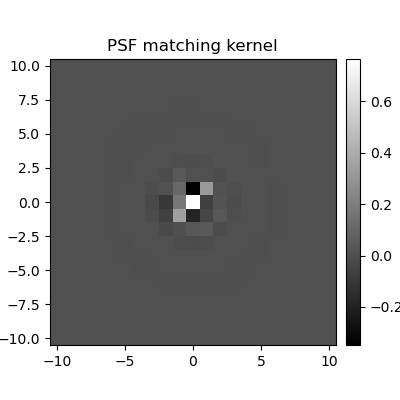

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))
disp = afwDisplay.Display(fig)
disp.image(kernelImage)
ax.set_title('PSF matching kernel')

Like all Exposures, the diffim has `image`, `mask`, and `variance` planes. Other common metadata is available via `visitInfo`, `psf`, and `photoCalib`.

In [27]:
dir(diffim)

['Factory',
 '__add__',
 '__class__',
 '__deepcopy__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__radd__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__rsub__',
 '__rtruediv__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '_get',
 '_pybind11_conduit_v1_',
 '_set',
 'apCorrMap',
 'clone',
 'containsSkyCoords',
 'convertD',
 'convertF',
 'convex_polygon',
 'detector',
 'dtype',
 'filter',
 'getBBox',
 'getConvexPolygon',
 'getCutout',
 'getDetector',
 'getDimensions',
 'getFilter',
 'getHeight',
 'getImage',
 'getInfo',
 'getMask',
 'getMaskedImage',
 'getMetadata',
 'getPhotoCalib',
 'getPsf',
 'getVariance',
 'getWcs',
 'getWidth',
 'getX0',
 'getXY0',
 'getY0',
 'hasPsf',
 'hasWcs',
 

### The next requirement concerns DIASource catalogs

We will load the diaSource catalog corresponding to the same difference image and show it has the required features.

>**DMS-REQ-0269** The DMS shall construct a catalog of all Sources detected on Diﬀerence Exposures with SNR > transSNR. For each Diﬀerence Source (DIASource), the DMS shall be able to provide the identity of the Diﬀerence Exposure from which it was derived; the identity of the associated SSObject, if any; the identity of the parent Source from which this DIASource has been deblended, if any. The DMS shall also measure and record a set of attributes for each DIASource including at least: epoch of the observation, focal plane position centroid and error (pixel), sky position and associated error (radec), SNR of the detection; calibrated PS flux and associated error; likelihood of the observed data given the PS model; calibrated aperture flux and associated error; calibrated flux and associated error for a trailed source model, and length and angle of the trail; flux and associated parameters for a dipole model; parameters of an adaptive shape measurement and associated error; a measure of source extendedness; the estimated background at the position of the object in the template image with associated uncertainty; a measure of spuriousness; and flags indicating problems encountered while computing the aforementioned attributes. The DMS shall also determine and record measurements on the Calibrated exposure the following: calibrated flux and associated error for the source as measured on the Visit image.

In [34]:
diaSrc = butler.get('goodSeeingDiff_diaSrc', visit=2024111600297, detector=1)

In [37]:
diaSrc

<class 'lsst.afw.table.SourceCatalog'>
        id              coord_ra      ... merge_footprint_negative
                          rad         ...                         
------------------ ------------------ ... ------------------------
191157012464140289 0.9232047715012827 ...                     True
191157012464140290 0.9221931435579899 ...                     True
191157012464140292 0.9237658210964208 ...                    False
191157012464140293  0.924059543941793 ...                    False
191157012464140294 0.9207634779000012 ...                     True
191157012464140295 0.9236075178634142 ...                    False
191157012464140296  0.923577160117373 ...                    False
191157012464140298 0.9221581063641828 ...                    False
191157012464140299 0.9248883448769114 ...                     True
               ...                ... ...                      ...
191157012464140389 0.9220304426717189 ...                     True
191157012464140390 0.92

In [39]:
diaSrc.schema

Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
    (Field['F'](name="coord_raErr", doc="1-sigma uncertainty on ra", units="rad"), Key<F>(offset=32, nElements=1)),
    (Field['F'](name="coord_decErr", doc="1-sigma uncertainty on dec", units="rad"), Key<F>(offset=36, nElements=1)),
    (Field['F'](name="coord_ra_dec_Cov", doc="uncertainty covariance between ra and dec", units="rad rad"), Key<F>(offset=40, nElements=1)),
    (Field['Flag'](name="is_negative", doc="Set if source peak was detected as negative."), Key['Flag'](offset=48, bit=0)),
    (Field['Flag'](name="detect_isPrimary", doc="True if source has no children and is not a sky source."), Key['Fl

This afwTable is produced immediately alongside the diffim. It is subsequently filtered, transformed, and/or consolidated depending on the specific Tasks in the pipeline being run (e.g., AP or DRP). Regardless of the pipeline, the user facing version of this catalog that is still per (visit, detector) dimensions is a pandas DataFrame called `goodSeeingDiff_diaSrcTable`.

In [35]:
diaSrcTable = butler.get('goodSeeingDiff_diaSrcTable', visit=2024111600297, detector=1)

In [36]:
diaSrcTable

,diaSourceId,visit,detector,band,diaObjectId,ssObjectId,parentDiaSourceId,midpointMjdTai,bboxSize,time_processed,...,shape_flag_parent_source,trail_flag_edge,pixelFlags_streak,pixelFlags_streakCenter,pixelFlags_injected,pixelFlags_injectedCenter,pixelFlags_injected_template,pixelFlags_injected_templateCenter,pixelFlags_nodata,pixelFlags_nodataCenter
0,191157012464140289,2024111600297,1,r,0,0,0,60631.329169,39,2025-03-03 03:40:03.902728,...,False,False,False,False,False,False,False,False,False,False
1,191157012464140290,2024111600297,1,r,0,0,0,60631.329169,26,2025-03-03 03:40:03.902728,...,False,False,False,False,False,False,False,False,False,False
2,191157012464140292,2024111600297,1,r,0,0,0,60631.329169,24,2025-03-03 03:40:03.902728,...,False,False,False,False,False,False,False,False,False,False
3,191157012464140293,2024111600297,1,r,0,0,0,60631.329169,21,2025-03-03 03:40:03.902728,...,False,False,False,False,False,False,False,False,False,False
4,191157012464140294,2024111600297,1,r,0,0,0,60631.329169,26,2025-03-03 03:40:03.902728,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,191157012464140394,2024111600297,1,r,0,0,0,60631.329169,13,2025-03-03 03:40:03.902728,...,False,False,False,False,False,False,False,False,False,False
93,191157012464140395,2024111600297,1,r,0,0,0,60631.329169,13,2025-03-03 03:40:03.902728,...,False,False,False,False,False,False,False,False,False,False
94,191157012464140396,2024111600297,1,r,0,0,0,60631.329169,13,2025-03-03 03:40:03.902728,...,False,False,False,False,False,False,False,False,False,False
95,191157012464140397,2024111600297,1,r,0,0,0,60631.329169,12,2025-03-03 03:40:03.902728,...,False,False,False,False,False,False,False,False,False,False


In [38]:
diaSrcTable.columns

Index(['diaSourceId', 'visit', 'detector', 'band', 'diaObjectId', 'ssObjectId',
       'parentDiaSourceId', 'midpointMjdTai', 'bboxSize', 'time_processed',
       'ra', 'dec', 'raErr', 'decErr', 'ra_dec_Cov', 'x', 'y', 'xErr', 'yErr',
       'apFlux', 'apFluxErr', 'snr', 'psfFlux', 'psfFluxErr', 'psfChi2',
       'psfNdata', 'trailFlux', 'trailRa', 'trailDec', 'trailLength',
       'trailAngle', 'dipoleMeanFlux', 'dipoleMeanFluxErr', 'dipoleFluxDiff',
       'dipoleFluxDiffErr', 'dipoleLength', 'dipoleAngle', 'dipoleChi2',
       'isDipole', 'dipoleFitAttempted', 'dipoleNdata', 'scienceFlux',
       'scienceFluxErr', 'ixx', 'iyy', 'ixy', 'ixxPSF', 'iyyPSF', 'ixyPSF',
       'extendedness', 'reliability', 'pixelFlags', 'pixelFlags_offimage',
       'pixelFlags_edge', 'pixelFlags_interpolated', 'pixelFlags_saturated',
       'pixelFlags_cr', 'pixelFlags_bad', 'pixelFlags_suspect',
       'pixelFlags_interpolatedCenter', 'pixelFlags_saturatedCenter',
       'pixelFlags_crCenter', 'pixelFl

### Let's look at each part of this requirement

For each Diﬀerence Source (DIASource), the DMS shall be able to provide:

* the identity of the Diﬀerence Exposure from which it was derived;
* the identity of the associated SSObject, if any;
* the identity of the parent Source from which this DIASource has been deblended, if any

Each row of the `diaSrcTable` above includes `visit` and `detector`, which uniquely identify the difference exposure from which it was derived. The `ssObjectId` column corresponds to the identify of the associated SSObject, if any. At present, deblending is not configured to run on difference images, but if it were, parent Source identities would be available in the `parentDiaSourceId` column.

In our example `diaSrcTable`, the `visit` and `detector` fields are all the same because one such table exists for each difference image. The `ssObjectId` and `parentDiaSourceId` columns are all 0 because there are no relevant associations.

In [41]:
diaSrcTable[['diaSourceId', 'visit', 'detector', 'ssObjectId', 'parentDiaSourceId']]

,diaSourceId,visit,detector,ssObjectId,parentDiaSourceId
0,191157012464140289,2024111600297,1,0,0
1,191157012464140290,2024111600297,1,0,0
2,191157012464140292,2024111600297,1,0,0
3,191157012464140293,2024111600297,1,0,0
4,191157012464140294,2024111600297,1,0,0
...,...,...,...,...,...
92,191157012464140394,2024111600297,1,0,0
93,191157012464140395,2024111600297,1,0,0
94,191157012464140396,2024111600297,1,0,0
95,191157012464140397,2024111600297,1,0,0


### Let's make a simple table for the next set of requirements

The DMS shall also measure and record a set of attributes for each DIASource including at least:

| Requirement            | diaSrcTable column name(s)  |
|------------------------|-----------------------------|
| epoch of the observation | `midpointMjdTai` |
| focal plane position centroid and error (pixel) | `x`, `y`, `xErr`, and `yErr` |
| sky position and associated error (radec) | `ra`, `dec`, `raErr`, `decErr`, and `ra_dec_Cov` |
| SNR of the detection | `snr` |
| calibrated PS[F] flux and associated error | `psfFlux` and `psfFluxErr` |
| likelihood of the observed data given the PS[F] model | `psfChi2` |
| calibrated aperture flux and associated error | `apFlux` and `apFluxErr` |
| calibrated flux and associated error for a trailed source model... | `trailFlux` and **`trailFluxErr` ⚠️MISSING⚠️** |
| ...and length and angle of the trail | `trailLength` and `trailAngle` |
| flux and associated parameters for a dipole model | `dipoleMeanFlux`, many more `dipole*`, and `isDipole` |
| parameters of an adaptive shape measurement and associated error | `ixx`, `iyy`, `ixy` (adaptive moments of the source) and `ixxPSF`, `iyyPSF`, `ixyPSF` (adaptive moments of the PSF) |
| a measure of source extendedness | `extendedness` |
| the estimated background at the position on the object in the template image with associated uncertainty | **HAVE NOT FOUND THESE YET** |
| a measure of spuriousness | `reliability` |
| flags indicating problems encountered while computing the aforementioned attributes | `*Flags*` and `*_flag` (there are many!) |

The DMS shall also determine and record measurements on the Calibrated exposure the following:

* calibrated flux and
* associated error for the source as measured on the Visit image.

These are also available in the `diaSrcTable` in the columns `scienceFlux` and `scienceFluxErr`.